In [233]:
# add in necessary libraries
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from plotly import express as px
import plotly.graph_objs as go

In [200]:
# ML libraries - idk which one to use yet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# NASA API

- Import Nasa data my requesting data through API. I wanted to get the parameters I thought were important which was precipitation, temperature, windspeed, and frost.
- NASA API will be used for retrieving current information to update app (by user location or routine hourly update)
    - routine hourly update should be for center of major cities bc too much to retrieve every single coordinate weather?
- `get_nasa_power_data` function will fetch NASA data for given latitude, longitude, and time range
- weather information retrieved from NASA should match fields in US Accident Data bc that is what it is trained on

In [194]:
# NASA API
def get_nasa_power_data(lat, lon, start_date, end_date):
    """
    Fetches NASA POWER API data for given latitude, longitude, and time range.

    Args:
    - lat (float): Latitude of the location.
    - lon (float): Longitude of the location.
    - start_date (str): Start date in YYYYMMDD format.
    - end_date (str): End date in YYYYMMDD format.

    Returns:
    - Pandas DataFrame with selected weather parameters.
    """

    # Specify multiple parameters in the API request
    parameters = "PRECSNO,T2MDEW,PRECTOTCORR,T2M,WS2M"

    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(url, params=params)

    data = response.json()

    # Convert JSON response to DataFrame and transpose it
    nasa_weather = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T

    # Reset index and rename date column
    nasa_weather.reset_index(inplace=True)
    nasa_weather.rename(columns={"index": "date"}, inplace=True)

    # Convert date column to proper datetime format
    nasa_weather["date"] = pd.to_datetime(nasa_weather["date"], format="%Y%m%d", errors="coerce")
    nasa_weather.dropna(subset=["date"], inplace=True)  # Remove invalid date rows

    nasa_weather.rename(columns={
        "PRECSNO": "Snow_Precipitation",
        "T2MDEW": "Dew_Point_2m",
        "PRECTOTCORR": "Total_Precipitation_mm",
        "T2M": "Temperature_2m_C",
        "WS2M": "Wind_Speed_2m"
    }, inplace=True)
    
    # Add Rounded_Lat and Rounded_Lng for merging
    nasa_weather['Rounded_Lat'] = lat
    nasa_weather['Rounded_Lng'] = lon
    
    # Display DataFrame
    print(f"\n Weather Data for Latitude {lat}, Longitude {lon}\n")
    display(nasa_weather)  # Works in Jupyter Notebook

    return nasa_weather

In [198]:
# Example: Fetch data for different locations
df_la = get_nasa_power_data(34.05, -118.25, "20240101", "20240107")  # Los Angeles
df_nyc = get_nasa_power_data(40.71, -74.01, "20240101", "20240107")  # New York City
df_sf = get_nasa_power_data(37.77, -122.42, "20240101", "20240107")  # San Francisco


 Weather Data for Latitude 34.05, Longitude -118.25



,date,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng
0,2024-01-01,0.0,6.12,0.04,12.14,1.64,34.05,-118.25
1,2024-01-02,0.0,7.05,0.09,11.55,1.59,34.05,-118.25
2,2024-01-03,0.0,6.75,5.87,10.86,3.25,34.05,-118.25
3,2024-01-04,0.0,2.14,0.02,9.76,2.89,34.05,-118.25
4,2024-01-05,0.0,1.99,0.00,10.80,2.00,34.05,-118.25
5,2024-01-06,0.0,1.23,0.12,10.50,2.86,34.05,-118.25
6,2024-01-07,0.0,-0.09,0.26,7.77,5.29,34.05,-118.25



 Weather Data for Latitude 40.71, Longitude -74.01



,date,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng
0,2024-01-01,0.00,2.07,0.04,4.98,2.65,40.71,-74.01
1,2024-01-02,0.00,-1.32,0.00,2.20,4.09,40.71,-74.01
2,2024-01-03,0.00,-0.04,0.00,3.46,3.09,40.71,-74.01
3,2024-01-04,0.00,-0.60,0.01,3.29,4.93,40.71,-74.01
4,2024-01-05,0.00,-3.65,0.00,0.51,4.52,40.71,-74.01
5,2024-01-06,0.86,0.18,30.07,3.13,5.14,40.71,-74.01
6,2024-01-07,0.09,2.15,7.85,3.27,6.36,40.71,-74.01



 Weather Data for Latitude 37.77, Longitude -122.42



,date,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng
0,2024-01-01,0.0,8.43,0.09,10.87,1.29,37.77,-122.42
1,2024-01-02,0.0,9.90,11.01,11.44,2.69,37.77,-122.42
2,2024-01-03,0.0,8.37,2.65,10.38,2.86,37.77,-122.42
3,2024-01-04,0.0,8.80,0.10,10.35,2.11,37.77,-122.42
4,2024-01-05,0.0,8.66,0.08,11.10,1.73,37.77,-122.42
5,2024-01-06,0.0,7.94,4.30,9.32,3.29,37.77,-122.42
6,2024-01-07,0.0,4.05,0.08,7.51,2.79,37.77,-122.42


# US Accident Data (Kaggle)

- Make sure that you downloaded the accident data and then import it sas a dataframe
- severity of accident will be target data for ML model

In [5]:
# inspect us_accident data
us_accidents = pd.read_csv('US_Accidents_March23.csv')
us_accidents.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [ ]:
# list of all columns in US Accident Data
drop_cols = ['ID',
            'Source',
            # 'Severity', # Severity = target column, 1-4, where 1 indicates the least impact on traffic
            'Start_Time',
            'End_Time',
            'Start_Lat',  
            'Start_Lng', 
            'End_Lat',
            'End_Lng',
            'Distance(mi)', # Distance(mi) = target column?, length of road extent affected by accident in miles
            'Description', # Description = human description of accident
            'Street', 
            'City', 
            'County',
            'State',
            'Zipcode',
            'Country',
            'Timezone',
            'Airport_Code',
            'Weather_Timestamp', # Weather_Timestamp = shows time-stamp of weather observation record (in local time)
            # 'Temperature(F)',
            # 'Wind_Chill(F)',
            # 'Humidity(%)',
            # 'Pressure(in)',
            # 'Visibility(mi)',
            # 'Wind_Direction',
            # 'Wind_Speed(mph)',
            # 'Precipitation(in)',
            # 'Weather_Condition',
            'Amenity',
            'Bump',
            'Crossing',
            'Give_Way',
            'Junction',
            'No_Exit',
            'Railway',
            'Roundabout',
            'Station',
            'Stop',
            'Traffic_Calming',
            'Traffic_Signal',
            'Turning_Loop',
            # 'Sunrise_Sunset', # day or night based on sunrise/sunset
            'Civil_Twilight', # day or night based on civil twilight
            'Nautical_Twilight', # day or night based on nautical twilight
            'Astronomical_Twilight'] # day or night based on astronomical twilight

In [209]:
# string feature that if kept will need to be encoded for ML
str_features = ['Wind_Direction',
            'Weather_Condition',
            'Sunrise_Sunset']

In [225]:
def prepare_data(df, split, ml_keep=[]):
    """
    Prepares the US Accidents DataFrame for merging with NASA weather data, keeping only necessary columns.
    
    Args:
    - df (DataFrame): Raw US Accidents dataset.
    - split (boolean): if true, split df by target and predictor data
    - ml_drop (list): other columns to drop for machine learning model (adjustable if we decide a variable is not good at predicting)
    
    Returns:
    - DataFrame: Processed DataFrame with 'date', 'Rounded_Lat', 'Rounded_Lng', and 'Severity' columns.
    """
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    
    # Convert time columns to datetime format
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

    # Remove rows with invalid 'Start_Time' values
    df = df[df['Start_Time'].notnull()].copy()

    # Extract 'date' from 'Start_Time' for merging with NASA weather data
    df['date'] = df['Start_Time'].dt.date

    # Filter for coordinates within LA County
    # could use 'County' to filter
    # df = df[df['County'] == 'Los Angeles']
    df = df[(df['Start_Lat'].between(33.7, 34.8)) & (df['Start_Lng'].between(-119.0, -117.6))]

    # Round latitude and longitude to 2 decimal places for approximate matching
    df['Rounded_Lat'] = df['Start_Lat'].round(2)
    df['Rounded_Lng'] = df['Start_Lng'].round(2)

    # Keep only relevant columns for merging
    # df = df[['date', 'Rounded_Lat', 'Rounded_Lng', 'Severity']]
    df = df.drop(drop_cols, axis=1)
    
    # encode str_features
    for feature in str_features:
        df[feature] = le.fit_transform(df[feature])
    
    # drop NaN
    df = df.dropna()
    
    if split:
        X=df[ml_keep]
        y=df['Severity']
        return X,y

    return df


In [221]:
# inspect would-be cleaned data
new_us_accidents = prepare_data(us_accidents, split=False)
new_us_accidents

,Severity,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,date,Rounded_Lat,Rounded_Lng
42863,2,87.0,87.0,35.0,29.11,10.0,14,8.0,0.0,7,0,2016-06-21,34.27,-118.64
42879,3,87.0,87.0,35.0,29.11,10.0,14,8.0,0.0,7,0,2016-06-21,34.34,-118.51
42970,2,94.0,94.0,31.0,29.08,10.0,14,9.0,0.0,7,0,2016-06-21,34.45,-118.58
43012,3,87.0,87.0,40.0,29.08,10.0,14,10.0,0.0,7,0,2016-06-21,34.35,-118.54
43016,2,85.0,85.0,44.0,29.07,10.0,12,10.0,0.0,7,0,2016-06-21,34.40,-118.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728382,2,79.0,79.0,50.0,29.70,10.0,18,5.0,0.0,7,0,2019-08-23,33.85,-117.84
7728384,2,78.0,78.0,52.0,29.69,10.0,18,6.0,0.0,7,0,2019-08-23,34.06,-118.00
7728387,2,75.0,75.0,60.0,29.74,10.0,15,9.0,0.0,7,0,2019-08-23,33.74,-117.84
7728391,2,73.0,73.0,64.0,29.74,10.0,15,10.0,0.0,37,0,2019-08-23,33.78,-117.85


In [99]:
# range of accident data
print(new_us_accidents['date'].min(), new_us_accidents['date'].max())


2016-03-22 2023-03-31


### Merging Example

- merge US accidents and NASA
- idk if we need this for training model but good code to keep :)
- we could always merge if we need more training data bc dropping NaN gets rid of a lot of data? maybe not a merge but a point replace of NaN to whatever NASA can fill in
- I just put an example for UCLA and this week , this is what we will get from user input?

In [94]:
# Fetch NASA weather data for UCLA (Jan 1, 2025 - Jan 7, 2025)
# coordinates must be rounded to 2 decimal places like accident data
nasa_weather_ucla = get_nasa_power_data(34.06, -118.44, '2020604', '20201025')


 Weather Data for Latitude 34.06, Longitude -118.44



,date,Snow_Precipitation,Dew_Point_2m,Total_Precipitation_mm,Temperature_2m_C,Wind_Speed_2m,Rounded_Lat,Rounded_Lng
0,2020-06-04,0.0,14.88,0.02,17.87,2.32,34.06,-118.44
1,2020-06-05,0.0,14.42,0.35,17.58,2.97,34.06,-118.44
2,2020-06-06,0.0,12.86,0.02,17.85,3.68,34.06,-118.44
3,2020-06-07,0.0,8.01,0.00,18.41,3.79,34.06,-118.44
4,2020-06-08,0.0,5.97,0.00,20.39,4.00,34.06,-118.44
...,...,...,...,...,...,...,...,...
139,2020-10-21,0.0,12.99,0.01,17.97,1.46,34.06,-118.44
140,2020-10-22,0.0,15.22,0.02,18.27,1.80,34.06,-118.44
141,2020-10-23,0.0,14.96,0.02,18.45,1.84,34.06,-118.44
142,2020-10-24,0.0,14.08,0.02,17.81,2.40,34.06,-118.44


In [117]:
# test run
import sqlite3

# Create a persistent SQLite database
conn = sqlite3.connect("accidents_weather_ucla.db")

# Ensure 'date' columns are strings for SQL
new_us_accidents['date'] = new_us_accidents['date'].astype(str)
nasa_weather_ucla['date'] = nasa_weather_ucla['date'].astype(str)

# Load datasets into the SQLite database
new_us_accidents.to_sql("accident_data", conn, index=False, if_exists="replace")
nasa_weather_ucla.to_sql("weather_data", conn, index=False, if_exists="replace")

# SQL query to merge on 'date', 'Rounded_Lat', and 'Rounded_Lng'
# inner join so we don't have accident data without weather data
query = """
SELECT a.date, 
    a.Rounded_Lat, 
    a.Rounded_Lng, 
    a.Severity,
    w.Total_Precipitation_mm AS Total_Precipitation_mm,
    w.Temperature_2m_C AS Temperature_2m_C,
    w.Wind_Speed_2m AS Wind_Speed_2m,
    w.Snow_Precipitation AS Snow_Precipitation,
    w.Dew_Point_2m AS Dew_Point_2m
FROM accident_data a
INNER JOIN weather_data w 
    ON a.date = w.date 
    AND a.Rounded_Lat = w.Rounded_Lat 
    AND a.Rounded_Lng = w.Rounded_Lng
"""

# Execute the query and fetch the merged result
merged_data = pd.read_sql_query(query, conn)

# Display the merged data
print(merged_data.head())

# Close the database connection
conn.close()



         date  Rounded_Lat  Rounded_Lng  Severity  Total_Precipitation_mm  \
0  2020-10-15        34.06      -118.44         2                     0.0   
1  2020-10-15        34.06      -118.44         2                     0.0   

   Temperature_2m_C  Wind_Speed_2m  Snow_Precipitation  Dew_Point_2m  
0             26.17            1.7                 0.0         11.52  
1             26.17            1.7                 0.0         11.52  


### Exploratory Analysis

- some simple scatter plot code to see if any features have increased likelihood of some severity
- i didn't try all combinations yet

In [187]:
# exploratory analysis for feature selection?
def scatter(df, x, y):
    fig = px.scatter(df, x=col[x], y=col[y], color='Severity',
                    color_continuous_scale=px.colors.diverging.Geyser) 
    fig.show()

In [182]:
col={1: 'Temperature(F)',
    2:'Wind_Chill(F)',
    3:'Humidity(%)',
    4:'Pressure(in)',
    5:'Visibility(mi)',
    6:'Wind_Direction',
    7:'Wind_Speed(mph)',
    8:'Precipitation(in)',
    9:'Weather_Condition',
    10:'Sunrise_Sunset',}

In [ ]:
scatter(new_us_accidents,x=5,y=9)

In [188]:
scatter(new_us_accidents,x=1,y=2)

In [190]:
scatter(new_us_accidents,x=7,y=8)

In [191]:
scatter(new_us_accidents,x=7,y=9)

In [253]:
fig = px.scatter_mapbox(new_us_accidents,
        lon ='Rounded_Lat',
        lat = 'Rounded_Lng',
        text = 'Severity',
        color = 'Severity',
        color_continuous_scale = px.colors.diverging.Geyser
        )

fig.update_layout(
        title = 'US Accident Data',
        geo = dict(
            projection_scale=15, 
            center=dict(lat=34.06, lon=-118.44),# center on ucla ish coords
        )
    )

fig.show()
# i can't tell if this isn't showing a map bc the code is wrong or bc it takes really long to load

# Machine Learning Model

## Training the Model

- this takes really long to run sorry
- ideally we can add more than just 2 variables lol
- first test uses temp, wind speed, and precipitation bc that's what we can get from NASA

In [256]:
# assumes new_us_accidents is cleaned
train, test = train_test_split(us_accidents, test_size=0.3)

# ml_keep based on which columns should be used to predict severity
# see col dict above to know which is which
X_train, y_train = prepare_data(train, split=True, ml_keep=[col[1],col[7],col[8]])
X_test, y_test = prepare_data(test, split=True, ml_keep=[col[1],col[7],col[8]])
X_train

,Temperature(F),Wind_Speed(mph),Precipitation(in)
1695119,70.0,7.0,0.0
1859308,77.0,5.0,0.0
7369439,87.0,5.0,0.0
7221382,79.0,3.0,0.0
4586882,49.0,0.0,0.0
...,...,...,...
625164,68.0,13.0,0.0
4857346,57.0,6.0,0.0
3660712,51.0,5.0,0.0
5998547,73.0,5.0,0.0


In [257]:
# random forest ML model
random_forest = RandomForestClassifier(random_state=10)
parameters = {"n_estimators": [50, 100, 200, 250, 300], 
              "max_depth": list(range(1, 10))}
cv_scores = []

#try every combination of estimators and max depth, recording them and their scores
for n in parameters['n_estimators']:
    for md in parameters['max_depth']:
        random_forest.set_params(n_estimators = n, max_depth = md)
        scores = cross_val_score(random_forest, X_train, y_train, cv=5)
        cv_scores.append({"n_estimators": n, "max_depth": md,
                          "mean_accuracy": np.mean(scores)})

best_params = max(cv_scores, key=lambda x: x["mean_accuracy"]) #find the parameters with the highest (best) cv score
best_params


{'n_estimators': 100, 'max_depth': 9, 'mean_accuracy': 0.873488858393779}

In [258]:
# create model with optimal estimators and max depth
test_model = RandomForestClassifier(n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"])
test_model.fit(X_train, y_train)
print(test_model.score(X_train, y_train))
print(test_model.score(X_test, y_test))


0.8735454921692914
0.8750860080139232


In [259]:
def plot_matrix(cm, labels, model):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    ax = disp.plot()
    ax.ax_.set_title(f"Confusion Matrix for Accident Severity with {model}")

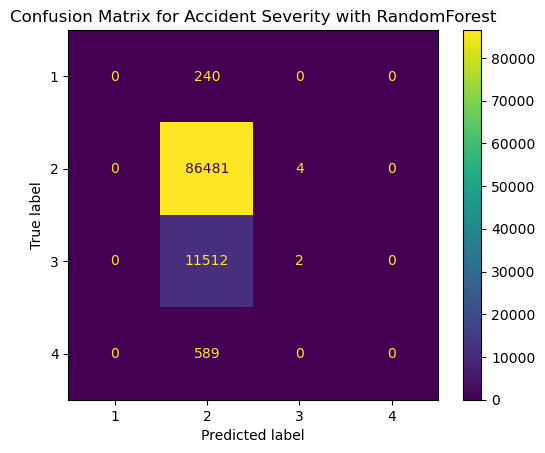

In [260]:
y_pred = test_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred) #make a confusion matrix from the predicted and actual test data
plot_matrix(cm, ["1", "2", "3", "4"], "RandomForest")